In [1]:
import glob
import regex
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = './ustawy/'
file_names = sorted(glob.glob(PATH + "*"))
file_names[:5]

['./ustawy/1993_599.txt',
 './ustawy/1993_602.txt',
 './ustawy/1993_645.txt',
 './ustawy/1993_646.txt',
 './ustawy/1994_150.txt']

In [3]:
class LawAct:
    def __init__(self, file_name, content):
        self.file_name = file_name
        self.year = file_name.split('/')[-1].split('_')[0]
        self.content = content
        self.additions = 0
        self.removals = 0
        self.changes = 0
        
law_acts =[]
for file_name in file_names:
    with open(file_name, "r") as f:
        law_acts.append(LawAct(file_name, f.read()))

# Zadanie 1 i 2

## Dodania jednostek

Na początek wyznaczę liczbę dodanych jednostek dla każdej ustawy. Żeby przygotować odpowiedni regex najpierw wyświetlam wystąpienia krótkiej frazy 'dodaje się' i jej otoczenia.

In [4]:
number_of_examples = 50
context_length_left = 5
context_length_right = 10

In [5]:
reg = regex.compile(r"dodaje się", regex.IGNORECASE)
law_acts_sample = np.array(law_acts)[np.random.choice(len(law_acts), number_of_examples, replace=False)]

for law_act in law_acts_sample:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start - context_length_left: end + context_length_right])
        print('--------------------------')

. 55 dodaje się ust. 3 w 
--------------------------
t. 9 dodaje się art. 9a w
--------------------------
. 8a dodaje się ust. 3 i 
--------------------------
 227 dodaje się ust. 4 i 
--------------------------
t. 1 dodaje się ust. 1a w
--------------------------
 19b dodaje się art. 19c 
--------------------------
. 24 dodaje się art. 24a 
--------------------------
 1 i dodaje się  ust. 2 w
--------------------------
 1 i dodaje się ust. 2–4 
--------------------------
. 39
dodaje się art. 391w
--------------------------
. 40
dodaje się art. 401–
--------------------------
. 42
dodaje się art. 421–
--------------------------
t. 1 dodaje się ust. 1a w
--------------------------
em i dodaje się pkt 6 w
b
--------------------------
t. 1 dodaje się ust. 1a w
--------------------------
t
44 dodaje się pkt 44a w
--------------------------
. 24
dodaje się art. 24a 
--------------------------
t. 1
dodaje się ust. 1a w
--------------------------
t. 1 dodaje się ust. 1a w
--------------------

Otrzymane wyniki pozwalają zbudować intuicję odnośnie tego czego szukamy - szukamy wystąpień frazy dodaje się po których nastepuje odpowiednie słowo/skrót oznaczające jednostkę (unit z treści zadania)

Wypiszę więc wszystkie unikatowe słowa występujące po 'dodaje się'

In [6]:
reg = regex.compile(r"dodaje\s+się\s+[\w§]+", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        phrases.append(law_act.content[start: end].split()[-1].lower())

for phrase in np.unique(phrases):
    print(phrase)

2
2a
3
38a
4
5a
art
cyfrę
drugie
dwukropek
dwukrotnie
dział
informację
każdorazowo
kropkę
kwotę
lit
litery
lp
masę
na
nowe
nowy
oddział
odnośnik
określenie
ozna
oznaczenie
pkt
po
poz
pozycję
przecinek
punkt
rozdział
rozdziały
tiret
trzecie
trzykrotnie
tytuł
ust
usta
użyte
użyty
w
wraz
wyraz
wyrazy
zadanie
załącznik
zdania
zdanie
§
§1a
§2
§3
średnik


Ręcznie sprawdzam kontekst dopasowań fraz zakończonych bardziej "podejrzanymi" słowami, żeby sprawdzić czy na pewno powinny pojawić się w docelowym regexie i nie wymagają dodatkowych warunków

In [7]:
reg = regex.compile(r"dodaje\s+się\s+usta", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start: end + 10])

dodaje się usta. 2a w brz


Analizując powyższe wyniki, po sprawdzeniu dopasowań z kontekstem, jako "addition of a unit" traktował będę frazy zawierające po 'dodaje się':
- [numer]
- art
- dział
- litery
- lit
- oddział
- pkt
- poz
- pozycję
- punkt
- rozdziały
- rozdział
- usta
- ust
- załącznik
- §
- czasami pomiędzy 'dodaje się' a końcówką może wystąpić również słowo 'nowy' albo 'nowe'

Dodatkowo ulepszony regex powinien być odporny na niestandardowe/niepoprawne znaki białe

In [8]:
phrase_ending = '(\d+|art|dział|litery|lit|oddział|pkt|poz|pozycję|punkt|rozdziały|rodział|usta|ust|załącznik|§)'

reg = regex.compile(r"(dodaje\s+się\s+(nowy\s+|nowe\s+)?ENDING)".replace('ENDING', phrase_ending), regex.IGNORECASE)

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        law_act.additions = law_act.additions + 1

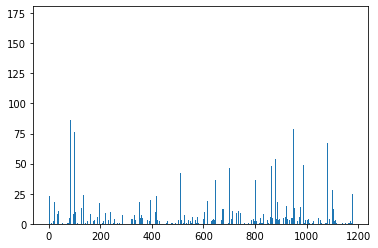

In [9]:
plt.bar(range(len(law_acts)), [law_act.additions for law_act in law_acts])
plt.show()

## Usunięcia jednostek

W analogiczny sposób wyznaczę liczbę usunięć jednostek. Żeby przygotować odpowiedni regex najpierw wyświetlam wystąpienia krótkiej frazy 'skreśla się' i jej otoczenia.

In [10]:
number_of_examples = 50
context_length_left = 15
context_length_right = 15

In [11]:
reg = regex.compile(r"skreśla się", regex.IGNORECASE)
law_acts_sample = np.array(law_acts)[np.random.choice(len(law_acts), number_of_examples, replace=False)]

for law_act in law_acts_sample:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start - context_length_left: end + context_length_right])
        print('--------------------------')


   a) w pkt 1 skreśla się wyrazy "posiad
--------------------------
isją",",
   c) skreśla się pkt 5,
   d) d
--------------------------
e Polski.";
6) skreśla się art. 5a;
7) w 
--------------------------
daniu wstępnym skreśla się wyrazy "biegłe
--------------------------
identa",
   b) skreśla się pkt 3,
   c) w
--------------------------
lnością.";
14) skreśla się art. 13;
15) a
--------------------------
ust. 1 w pkt 1 skreśla się wyraz "gospoda
--------------------------
,
   b) ust. 2 skreśla się;
20) w art. 18
--------------------------
   a) w ust. 1 skreśla się wyrazy "oraz p
--------------------------
   b) w ust. 3 skreśla się wyrazy "lub na
--------------------------
widentów" oraz skreśla się wyrazy "będący
--------------------------
   a) w ust. 1 skreśla się przecinek i wy
--------------------------
 ust. 1.";
10) skreśla się art. 12 - 16;

--------------------------
. 12 - 16;
11) skreśla się wyrazy "Rozdzi
--------------------------
;
2) w art. 52 skreśla się pkt 5.


Intuicję odnośnie tego czego szukać już mamy - takie wystąpienia frazy skreśla się po których wystąpią skróty/słowa oznaczające jednostki (unit z treści zadania)

Teraz wyszukajmy wszystkie słowa występujące po skreśla się

In [12]:
reg = regex.compile(r"skreśla\s+się\s+[\w§]+", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        phrases.append(law_act.content[start: end].split()[-1].lower())

for phrase in np.unique(phrases):
    print(phrase)

1
11
art
drugie
dział
i
kropkę
lit
na
oddział
oraz
ostatnie
oznaczenie
pkt
powołanie
poz
pozostałą
preambułę
przecinek
przyimek
rozdział
rozdziały
tytuł
ust
użyte
użyty
w
wyraz
wyrazy
z
załącznik
zdania
zdanie
§


Ręcznie sprawdzam kontekst dopasowań fraz zakończonych bardziej "podejrzanymi" słowami, żeby sprawdzić czy na pewno powinny pojawić się w docelowym regexie i nie wymagają dodatkowych warunków

In [13]:
reg = regex.compile(r"skreśla\s+się\s+w pkt", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start: end+100])

skreśla się w pkt 13 lit. b w pkt 1.
                                Art. 4.
Ustawa wchodzi w życie z dniem ogłoszeni


Analizując powyższe wyniki jako "removal of a unit" traktował będę frazy zawierające po 'skreśla się':
- [numer]
- art
- dział
- lit
- oddział
- pkt
- poz (ale nie pozostałą - wystarczy zmatchować poz.)
- preambułę
- rozdziały
- rozdział
- ust
- w (konkretnie 'w ust', 'w dziale', 'w pkt')
- załącznik
- §

Dodatkowo ulepszony regex powinien być odporny na niestandardowe/niepoprawne znaki białe

In [14]:
phrase_ending = '(\d+|art|dział|lit|oddział|pkt|poz.|preambułę|rodziały|rozdział|ust|w ust|w dziale|w pkt|załącznik|§)'

reg = regex.compile(r"(skreśla\s+się\s+ENDING)".replace('ENDING', phrase_ending), regex.IGNORECASE)

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        law_act.removals = law_act.removals + 1

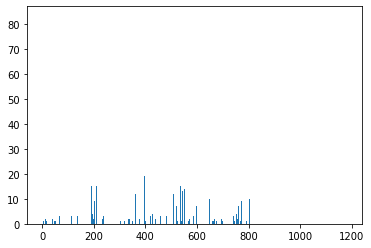

In [15]:
plt.bar(range(len(law_acts)), [law_act.removals for law_act in law_acts])
plt.show()

## Zmiany jednostek

W analogiczny sposób wyznaczę liczbę zmian jednostek. Żeby przygotować odpowiedni regex najpierw wyświetlam wystąpienia krótkiej frazy 'skreśla się' i jej otoczenia.

In [16]:
number_of_examples = 50
context_length_left = 15
context_length_right = 15

In [17]:
reg = regex.compile(r"otrzymuje brzmienie", regex.IGNORECASE)
law_acts_sample = np.array(law_acts)[np.random.choice(len(law_acts), number_of_examples, replace=False)]

for law_act in law_acts_sample:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start - context_length_left: end + context_length_right])
        print('--------------------------')

 art. 2 ust. 2 otrzymuje brzmienie:
   "2. Dyscyp
--------------------------
3:
   a) pkt 2 otrzymuje brzmienie:
     "2) prze
--------------------------
",
   c) pkt 5 otrzymuje brzmienie:
     "5) ukar
--------------------------
",
   d) pkt 6 otrzymuje brzmienie:
     "6) prze
--------------------------
",
   e) pkt 9 otrzymuje brzmienie:
     "9) orga
--------------------------
,
   f) pkt 10 otrzymuje brzmienie:
     "10) org
--------------------------
:
     - pkt 1 otrzymuje brzmienie:
        "1) M
--------------------------
,
   c) ust. 3 otrzymuje brzmienie:
     "3. Mini
--------------------------
:
   a) ust. 1 otrzymuje brzmienie:
     "1. Udzi
--------------------------
w ust. 1 pkt 3 otrzymuje brzmienie:
     "3) szcz
--------------------------
art. 15 ust. 3 otrzymuje brzmienie:
   "3. Żołnie
--------------------------
1:
   a) pkt 1 otrzymuje brzmienie:
     "1) czyn
--------------------------
",
   b) pkt 3 otrzymuje brzmienie:
     "3) czyn
--------------------------

Szukamy więc takich wystąpień frazy 'otrzymuje brzmienie', które poprzedzone są słowami zawierającymi oznaczenie jednostki (unit z treści zadania) która jest zmieniana

Wyszukajmy więc unikatowe trójki słów występujących przed 'otrzymuje brzmienie'

In [18]:
reg = regex.compile(r"[\w§1-9.]+\s+[\w§1-9.]+\s+[\w§1-9.]+\s+otrzymuje\s+brzmienie", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        phrases.append(" ".join(law_act.content[start: end].split()[:]).lower())

for phrase in np.unique(phrases):
    print(phrase)

1 część wspólna otrzymuje brzmienie
1 do ustawy otrzymuje brzmienie
1 i 2 otrzymuje brzmienie
1 lit. a otrzymuje brzmienie
1 lit. b otrzymuje brzmienie
1 lit. c otrzymuje brzmienie
1 lit. e otrzymuje brzmienie
1 lit. f otrzymuje brzmienie
1 lit. h otrzymuje brzmienie
1 lit. v otrzymuje brzmienie
1 pkt 1 otrzymuje brzmienie
1 pkt 10 otrzymuje brzmienie
1 pkt 11 otrzymuje brzmienie
1 pkt 12 otrzymuje brzmienie
1 pkt 13 otrzymuje brzmienie
1 pkt 14 otrzymuje brzmienie
1 pkt 15 otrzymuje brzmienie
1 pkt 17 otrzymuje brzmienie
1 pkt 1a otrzymuje brzmienie
1 pkt 2 otrzymuje brzmienie
1 pkt 21 otrzymuje brzmienie
1 pkt 22 otrzymuje brzmienie
1 pkt 23 otrzymuje brzmienie
1 pkt 25 otrzymuje brzmienie
1 pkt 26 otrzymuje brzmienie
1 pkt 2a otrzymuje brzmienie
1 pkt 3 otrzymuje brzmienie
1 pkt 30 otrzymuje brzmienie
1 pkt 37 otrzymuje brzmienie
1 pkt 38 otrzymuje brzmienie
1 pkt 4 otrzymuje brzmienie
1 pkt 40 otrzymuje brzmienie
1 pkt 44 otrzymuje brzmienie
1 pkt 47 otrzymuje brzmienie
1 pkt 4a ot

Ręcznie sprawdzam kontekst dopasowań fraz zakończonych bardziej "podejrzanymi" słowami, żeby sprawdzić czy na pewno powinny pojawić się w docelowym regexie i nie wymagają dodatkowych warunków

In [19]:
reg = regex.compile(r"[\w§1-9.]+\s+ust.\s+[\w§1-9.]+\s+otrzymuje\s+brzmienie", regex.IGNORECASE)
phrases = []

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        start, end = match.span()
        print(law_act.content[start: end+10])

90 ust. 
1 otrzymuje brzmienie:
       

15 ust. 1 otrzymuje brzmienie:
       "
16 ust. 1 otrzymuje brzmienie:
       "
18 ust. 2 otrzymuje brzmienie:
       "
20 ust. 2 otrzymuje brzmienie:
       "
57 ust. 2 otrzymuje brzmienie:
     "2.
35  ust. 5 otrzymuje brzmienie:
    "5. 
77 ust. 2 otrzymuje brzmienie:
    "2. 
1 ust. 1 otrzymuje brzmienie:
       "
21 ust. 2 otrzymuje brzmienie:
       "
30 ust. 4 otrzymuje brzmienie:
   "4. P
80 ust. 3 otrzymuje brzmienie:
       "
4 ust. 3 otrzymuje brzmienie:
  "3. Ra
1 ust. 1 otrzymuje brzmienie:
      "1
12 ust. 2 otrzymuje brzmienie:
      "2
16 ust. 1 otrzymuje brzmienie:
      "1
34 ust. 1 otrzymuje brzmienie:
      "1
38 ust. 1 otrzymuje brzmienie:
      "1
53 ust. 3 otrzymuje brzmienie:
      "3
56 ust. 2 otrzymuje brzmienie:
      "2
58 ust. 6 otrzymuje brzmienie:
      "6
75 ust. 1 otrzymuje brzmienie:
      "1
75 ust. 2 otrzymuje brzmienie:
    "2. 
5 ust. 2 otrzymuje brzmienie:
        
10 ust. 2 otrzymuje brzmienie:
      "2
27

42 ust. 2 otrzymuje brzmienie:
      "2
10 ust. 1 otrzymuje brzmienie:
      "1
10 ust. 2 otrzymuje brzmienie:
       "
12 ust. 2 otrzymuje brzmienie:
   "2. M
39 ust. 3 otrzymuje brzmienie:
   "3. W
4 ust. 2 otrzymuje brzmienie:
      "2
14 ust. 1 otrzymuje brzmienie:
      "1
19 ust. 2 otrzymuje brzmienie:
      "2
33 ust. 1 otrzymuje brzmienie:
      "1
5 ust. 2 otrzymuje brzmienie:
      "2
9 ust. 2 otrzymuje brzmienie:
      "2
1 ust. 2 otrzymuje brzmienie:
      "2
64 ust. 1 otrzymuje brzmienie:
      "1
20 ust. 3 otrzymuje brzmienie:
      "3
46 ust. 4 otrzymuje brzmienie:
        
2 ust. 1 otrzymuje brzmienie:
        
5 ust. 3 otrzymuje brzmienie:
      "3
27 ust. 3 otrzymuje brzmienie:
     "3.
5 ust. 4 otrzymuje brzmienie:
        
32 ust. 1 otrzymuje brzmienie:
        
25 ust. 1 otrzymuje brzmienie:
      "1
33 ust. 1 otrzymuje brzmienie:
      "1
58 
ust. 2 otrzymuje brzmienie:
      "2
1 ust. 2 otrzymuje brzmienie:
      "2
9 ust. 3 otrzymuje brzmienie:
      "3
39 ust. 

26 ust. 2 otrzymuje brzmienie:
     "2.
31 ust. 3 otrzymuje brzmienie:
     "3.
38a ust. 6 otrzymuje brzmienie:
     "6.
10 ust. 2 otrzymuje brzmienie:
     "2.
22 ust. 3 otrzymuje brzmienie:
     "3.
23 ust. 3 otrzymuje brzmienie:
     "3.
4 ust. 2 otrzymuje brzmienie:
     "2.
8 ust. 4 otrzymuje brzmienie:
     "4.
25 ust. 4 otrzymuje brzmienie:
     "4.
1 ust. 1 otrzymuje brzmienie:
     "1.
38 ust. 1 otrzymuje brzmienie:
      "A
17 ust. 2 otrzymuje brzmienie:
   "2. W
70 ust. 2 otrzymuje brzmienie:
   "2. Z
19 ust. 1 otrzymuje brzmienie:
   "1. W
3 ust. 2 otrzymuje brzmienie:
   "2. C
19 ust. 2 otrzymuje brzmienie:
   "2. P
14 ust. 2 otrzymuje brzmienie:
   "2. W
10 ust. 2 otrzymuje brzmienie:
     "2.
20 ust. 1 otrzymuje brzmienie:
     "1.
24 ust. 1 otrzymuje brzmienie:
   "1. R
16 ust. 4 otrzymuje brzmienie:
   "4. P
83 ust. 2 otrzymuje brzmienie:
  "2. Mi
105 ust. 2 otrzymuje brzmienie:
   "2. Z
3 ust. 1 otrzymuje
brzmienie:
   "1. M
4 ust. 2 otrzymuje brzmienie:
     "2.
6 us

2 ust. 2 otrzymuje brzmienie:
     "2.
3 ust. 3 otrzymuje brzmienie:
     "3.
13 ust. 2 otrzymuje brzmienie:
     "2.
53 ust. 1 otrzymuje brzmienie:
     "1.
6 ust. 1 otrzymuje brzmienie:
     "1.
12 ust. 1 otrzymuje brzmienie:
     "1.
19 ust. 1 otrzymuje brzmienie:
     "1.
22 ust. 3 otrzymuje brzmienie:
     "3.
7 ust. 2 otrzymuje brzmienie:
     "2.
32 ust. 3 otrzymuje brzmienie:
     "3.
9 ust. 3 otrzymuje brzmienie:
   "3. M
12 ust. 2 otrzymuje brzmienie:
     "2.
54 ust. 3 otrzymuje brzmienie:
   "3. O
18 ust. 2 otrzymuje brzmienie:
   "2. G
33d ust. 2 otrzymuje brzmienie:
     "2.
117 ust. 1 otrzymuje brzmienie:
     "1.
7 ust. 2 otrzymuje brzmienie:
     "2.
6 ust. 2 otrzymuje brzmienie:
  "2. W 
10 ust. 1 otrzymuje brzmienie:
     "1.
11 ust. 1 otrzymuje brzmienie:
   "1. O
11 ust. 1 otrzymuje brzmienie:
     "1.
2 ust. 1 otrzymuje brzmienie:
     "1.
16 ust. 2 otrzymuje brzmienie:
     "2.
34 ust. 1 otrzymuje brzmienie:
     "1.
26 ust. 2 otrzymuje brzmienie:
     "2.
13 ust

7 ust. 4 otrzymuje brzmienie:
  "4. Ra
13 ust. 4 otrzymuje brzmienie:
   "4. Z
27 ust. 3 otrzymuje brzmienie:
     "3.
12 ust. 1 otrzymuje brzmienie:
  "1. Cz
12 ust. 4 otrzymuje brzmienie:
  "4. Do
52 ust. 4 otrzymuje brzmienie:
     "4.
53 ust. 2 otrzymuje brzmienie:
     "2.
33 ust. 2 otrzymuje brzmienie:
  "2. W 
53 ust. 3 otrzymuje
brzmienie:
   "3. M
20 ust. 2 otrzymuje brzmienie:
     "2.
11 ust. 2 otrzymuje brzmienie:
     "2.
25 ust. 2 otrzymuje brzmienie:
     "2.
37 ust. 3 otrzymuje brzmienie:
     "3.
44 ust. 3 otrzymuje brzmienie:
     "3.
52 ust. 1 otrzymuje brzmienie:
     "1.
69 ust. 1 otrzymuje brzmienie:
     "1.
45 ust. 1 otrzymuje brzmienie:
   "1. Z
58 ust. 3 otrzymuje brzmienie:
   "3. J
59 ust. 3 otrzymuje brzmienie:
   "3. J
76 ust. 2 otrzymuje brzmienie:
   "2. P
50 ust. 1 otrzymuje brzmienie:
   "1. P
11 ust. 1 otrzymuje brzmienie:
     "1.
30 ust. 2 otrzymuje brzmienie:
     "2.
31 ust. 3 otrzymuje brzmienie:
     "3.
33 ust. 2 otrzymuje brzmienie:
   "2. M
3

15c ust. 1 otrzymuje brzmienie:
„1. W pr
20 ust. 2 otrzymuje brzmienie:
„2. Obow
26 ust. 4 otrzymuje brzmienie:
„4. Prze
72 ust. 4 otrzymuje brzmienie:
„4. W pr
86 ust. 3
otrzymuje brzmienie:
„3. Czło
42 ust.
1 otrzymuje brzmienie: 
„1.    
17
ust. 1 otrzymuje brzmienie:
„1. Decy
3 ust. 3 otrzymuje brzmienie:
„3. Za d
8 ust. 4 otrzymuje brzmienie:
„4. Do d
53a ust. 1 otrzymuje brzmienie:

„1. Opł
21 ust. 2 otrzymuje
brzmienie:
„2. Prze
38q ust. 3a otrzymuje brzmienie:
„3a. Dyr
7 ust. 1 otrzymuje brzmienie:
  "1. Do
7 ust. 2 otrzymuje brzmienie:
„2. Wyda
37l ust. 4 otrzymuje brzmienie:
„4. Wyda
37ad ust. 3 otrzymuje brzmienie: 
„3.
Na 
68 ust. 4
otrzymuje brzmienie:
„4.
Nie 
89a ust. 4 otrzymuje brzmienie:
„4.
Udzi
119a ust. 1 otrzymuje brzmienie:
„1.
Prod
129b ust. 2 otrzymuje brzmienie:
„2.
Karę
133a ust. 1 otrzymuje brzmienie:
„1. Kto 
7 ust. 4
otrzymuje brzmienie:
„4. Zada
18a ust.
1 otrzymuje brzmienie:
„1.     
18b ust.
3 otrzymuje brzmienie:
„3.     
47 ust. 4 otrzymuje brzmienie

61 ust. 4 otrzymuje brzmienie:
  "4.  P
139 ust. 2 otrzymuje brzmienie:
   "2. P
13 ust. 1 otrzymuje brzmienie:
   "1. Z
15 ust. 2 otrzymuje brzmienie:
   "2. O
18 ust. 3 otrzymuje brzmienie:
   "3. O
53 ust. 2 otrzymuje brzmienie:
   "2. P
66 ust. 2 otrzymuje brzmienie:
   "2. J
70 ust. 2 otrzymuje brzmienie:
   "2. O
215 ust. 2 otrzymuje brzmienie:
  "2. W 
9 ust.
2 otrzymuje brzmienie:
„2. Powi
11
ust. 3 otrzymuje brzmienie:
„3. Powi
27 ust. 9 otrzymuje brzmienie:
„9. Koni
52c
ust. 2 otrzymuje brzmienie:
„2. Labo
57
ust. 6 otrzymuje brzmienie:
„6. Głów
79
ust. 1 otrzymuje brzmienie:
„1. Kto 
25a
ust. 1 otrzymuje brzmienie:
„1.  W p
28
ust. 1 otrzymuje brzmienie:
„1. Poda
III ust. 39 otrzymuje brzmienie:


 
  
 
7 ust. 2
otrzymuje brzmienie:
„2. Kopi
42
ust. 3 otrzymuje brzmienie:
„3. Prze
49
ust. 3 otrzymuje brzmienie:
„3. W pr
59c
ust. 1 otrzymuje brzmienie:
„1. Właś
59g ust. 5 otrzymuje brzmienie:
„5. Do k
83
ust. 1 otrzymuje brzmienie:
„1. Do w
7 ust.
7 otrzymuje brzmienie:
„7. 

7 ust.
2 otrzymuje brzmienie:
„2.     
16
ust. 1 otrzymuje brzmienie:
„1.     
15 ust. 1 otrzymuje brzmienie:
  "1. Wn
17 ust. 3 otrzymuje brzmienie:
     "3.
34 ust. 3 otrzymuje brzmienie:
     "3.
36 ust. 1 otrzymuje brzmienie:
   "1. G
69 ust. 1 otrzymuje brzmienie:
  "1. Le
10 ust. 1 otrzymuje brzmienie:
  "1. Za
12 ust. 1 otrzymuje brzmienie:
   "1. P
20 ust. 1 otrzymuje brzmienie:
   "1. R
37 ust. 1 otrzymuje brzmienie:
     "1.
83 ust. 3 otrzymuje brzmienie:
  "3. Ni
66 ust. 1a otrzymuje brzmienie:
  "1a. A
77 ust. 3 otrzymuje brzmienie:
   "3. K
111 ust. 1 otrzymuje brzmienie:
     "1.
44 ust. 3 otrzymuje brzmienie:
„3. Mini
21 ust. 2
otrzymuje brzmienie:
„2. Prze
80a ust. 1 otrzymuje brzmienie:
   "1. P
86 ust. 2 otrzymuje brzmienie:
   "2. U
50 ust. 2 otrzymuje brzmienie:
„2. Prez
119 ust. 2 otrzymuje brzmienie:
„2. Bezr
120 ust. 2
otrzymuje brzmienie:
„2. Cudz
122 ust. 1
otrzymuje brzmienie:
„1.
Kto:
37h
ust. 3 otrzymuje brzmienie:
„3.     
101 ust. 1 otrzymuje brzmienie:
„1

Analizując powyższe wyniki jako "changeof a unit" traktował będę frazy zawierające jedno z poniższych słów jako drugie przed 'otrzymuje brzmienie':
- art
- lit
- ust
- §

Dodatkowo ulepszony regex powinien być odporny na niestandardowe/niepoprawne znaki białe

In [20]:
phrase_ending = '(art|lit|ust|§)'

reg = regex.compile(r"[\w§1-9.]+\s+TODO\s+[\w§1-9.]+\s+otrzymuje\s+brzmienie".replace('TODO', phrase_ending), regex.IGNORECASE)

for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        law_act.changes = law_act.changes + 1

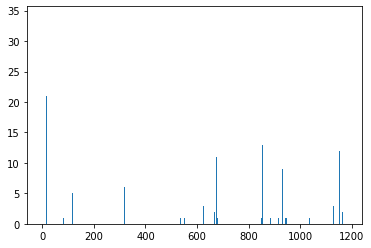

In [21]:
plt.bar(range(len(law_acts)), [law_act.changes for law_act in law_acts])
plt.show()

# Zadanie 3

In [22]:
years = np.unique([law_act.year for law_act in law_acts])
additions = {year: 0 for year in years}
removals = {year: 0 for year in years}
changes = {year: 0 for year in years}
combined_amendments = {year: 0 for year in years}

for law_act in law_acts:
    additions[law_act.year] += law_act.additions
    removals[law_act.year] += law_act.removals
    changes[law_act.year] += law_act.changes
    combined_amendments[law_act.year] += law_act.additions + law_act.removals + law_act.changes
    
additions_percentage = 100 * np.array(list(additions.values())) / np.array(list(combined_amendments.values()))
removals_percentage = 100 * np.array(list(removals.values())) / np.array(list(combined_amendments.values()))
changes_percentage = 100 * np.array(list(changes.values())) / np.array(list(combined_amendments.values()))
print(additions_percentage)
print(removals_percentage)
print(changes_percentage)
additions_percentage + removals_percentage + changes_percentage

[87.17948718 60.21505376 78.42227378 67.77188329 69.02834008 70.44025157
 72.72727273 69.17626218 78.81944444 90.19607843 91.01497504 95.09803922]
[12.82051282 22.58064516 19.72157773 29.44297082 29.55465587 25.78616352
 26.40692641 28.78653676 18.68055556  0.98039216  0.41597338  0.17825312]
[ 0.         17.20430108  1.85614849  2.78514589  1.41700405  3.77358491
  0.86580087  2.03720106  2.5         8.82352941  8.56905158  4.72370766]


array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.])

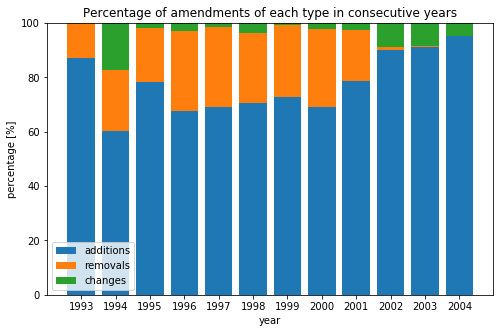

In [23]:
plt.figure(figsize=(8, 5))
plt.bar(years, additions_percentage, label='additions')
plt.bar(years, removals_percentage, bottom=additions_percentage, label='removals')
plt.bar(years, changes_percentage, bottom=additions_percentage + removals_percentage, label='changes')
plt.legend()
plt.title('Percentage of amendments of each type in consecutive years')
plt.xlabel('year')
plt.ylabel('percentage [%]')
plt.show()

# Zadanie 4

In [24]:
declination = [
    'ustawa', 
    'ustawy', 
    'ustawie', 
    'ustawę', 
    'ustawą', 
    'ustawo', 
    'ustawy', 
    'ustaw', 
    'ustawom', 
    'ustawami', 
    'ustawach'
]
regex_alt_form = '(' + '|'.join(declination) + ')'
regex_alt_form

'(ustawa|ustawy|ustawie|ustawę|ustawą|ustawo|ustawy|ustaw|ustawom|ustawami|ustawach)'

In [25]:
reg = regex.compile(r"\bWORDS\b".replace('WORDS', regex_alt_form), regex.IGNORECASE)

occurences = 0
matches = []
for law_act in law_acts:
    matches_iterator = reg.findall(law_act.content)
    for match in matches_iterator:
        occurences += 1
        matches.append(match)
        
print(np.unique(matches))
print('Number of occurences of the word \'ustawa\' in any form', occurences)

['USTAWA' 'USTAWY' 'USTAWa' 'Ustaw' 'Ustawa' 'Ustawie' 'Ustawy' 'Ustawę'
 'ustaw' 'ustawA' 'ustawa' 'ustawach' 'ustawami' 'ustawie' 'ustawom'
 'ustawy' 'ustawą' 'ustawę']
Number of occurences of the word 'ustawa' in any form 25092


# Zadanie 5

In [26]:
reg = regex.compile(r"\bWORDS\b(?=\s+z\s+dnia\b)".replace('WORDS', regex_alt_form), regex.IGNORECASE)

followed_occurences = 0
followed_matches = []
for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        followed_occurences += 1
        start, end = match.span()
        followed_matches.append(law_act.content[start: end])
        
print(np.unique(followed_matches))
print('Number of occurences of the word \'ustawa\' in any form followed by \'z dnia\' expression', followed_occurences)

['USTAWA' 'USTAWa' 'Ustawa' 'Ustawy' 'ustawA' 'ustawa' 'ustawach'
 'ustawie' 'ustawy' 'ustawą' 'ustawę']
Number of occurences of the word 'ustawa' in any form followed by 'z dnia' expression 8638


# Zadanie 6

In [27]:
reg = regex.compile(r"\bWORDS\b(?!\s+z\s+dnia\b)".replace('WORDS', regex_alt_form), regex.IGNORECASE)

not_followed_occurences = 0
not_followed_matches = []
for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        not_followed_occurences += 1
        start, end = match.span()
        not_followed_matches.append(" ".join(law_act.content[start: end].split()))
        
print(np.unique(not_followed_matches))
print('Number of occurences of the word \'ustawa\' in any form NOT followed by \'z dnia\' expression', not_followed_occurences)

['USTAWA' 'USTAWY' 'Ustaw' 'Ustawa' 'Ustawie' 'Ustawy' 'Ustawę' 'ustaw'
 'ustawa' 'ustawach' 'ustawami' 'ustawie' 'ustawom' 'ustawy' 'ustawą'
 'ustawę']
Number of occurences of the word 'ustawa' in any form NOT followed by 'z dnia' expression 16454


Sprawdźmy, czy liczba matchów się zgadza, czyli:

(wynik zadania 5) + (wynik zadania 6) = (wynik zadania 4)

In [28]:
occurences

25092

In [29]:
followed_occurences + not_followed_occurences

25092

In [30]:
followed_occurences + not_followed_occurences == occurences

True

# Zadanie 7

In [31]:
reg = regex.compile(r"(?<!\bo\s+zmianie\s+)\bWORDS\b".replace('WORDS', regex_alt_form), regex.IGNORECASE)

not_preceded_occurences = 0
not_preceded__matches = []
for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        not_preceded_occurences += 1
        start, end = match.span()
        not_preceded__matches.append(" ".join(law_act.content[start: end].split()))
        
print(np.unique(not_preceded__matches))
print('Number of occurences of the word \'ustawa\' in any form NOT preceded by \'o zmianie\' expression', not_preceded_occurences)

['USTAWA' 'USTAWY' 'USTAWa' 'Ustaw' 'Ustawa' 'Ustawie' 'Ustawy' 'Ustawę'
 'ustaw' 'ustawA' 'ustawa' 'ustawach' 'ustawami' 'ustawie' 'ustawom'
 'ustawy' 'ustawą' 'ustawę']
Number of occurences of the word 'ustawa' in any form NOT preceded by 'o zmianie' expression 24226


In [32]:
reg = regex.compile(r"(?<=\bo\s+zmianie\s+)\bWORDS\b".replace('WORDS', regex_alt_form), regex.IGNORECASE)

preceded_occurences = 0
preceded__matches = []
for law_act in law_acts:
    matches_iterator = reg.finditer(law_act.content)
    for match in matches_iterator:
        preceded_occurences += 1
        start, end = match.span()
        preceded__matches.append(" ".join(law_act.content[start: end].split()))
        
print(np.unique(preceded__matches))
print('Number of occurences of the word \'ustawa\' in any form preceded by \'o zmianie\' expression', preceded_occurences)

['Ustawy' 'ustaw' 'ustawy']
Number of occurences of the word 'ustawa' in any form preceded by 'o zmianie' expression 866


Sprawdźmy, czy liczba matchów się zgadza, czyli liczba wystąpień nie poprzedzonych wyrażeniem o zmianie zsumowana z liczbą wystąpień poprzedzonych tym wyrażeniem daje nam sumaryczną liczbę wystąpień słowa ustawa w dodowlnej formie

In [33]:
occurences

25092

In [34]:
preceded_occurences + not_preceded_occurences

25092

In [35]:
preceded_occurences + not_preceded_occurences == occurences

True

# Zadanie 8

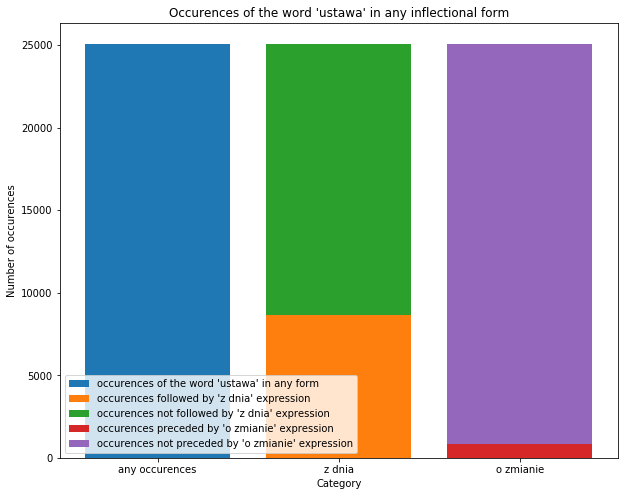

In [36]:
plt.figure(figsize=(10, 8))
plt.bar("any occurences", occurences, label="occurences of the word 'ustawa' in any form")

plt.bar("z dnia", followed_occurences, label="occurences followed by 'z dnia' expression")
plt.bar("z dnia", not_followed_occurences, bottom=followed_occurences, label="occurences not followed by 'z dnia' expression")

plt.bar("o zmianie", preceded_occurences, label="occurences preceded by 'o zmianie' expression")
plt.bar("o zmianie", not_preceded_occurences, bottom=preceded_occurences, label="occurences not preceded by 'o zmianie' expression")

plt.legend(loc=3)
plt.title("Occurences of the word 'ustawa' in any inflectional form")
plt.xlabel('Category')
plt.ylabel('Number of occurences')
plt.show()